In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

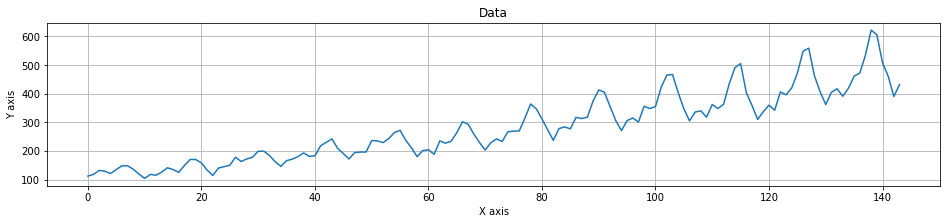

In [2]:
fileName = 'datosT1P2.txt'
data = np.loadtxt(fileName)

fig = plt.figure(0,(16,3))
plt.plot(data[:,0],data[:,1])
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.grid()
plt.show(fig)

Total data: 144
Train data: 108
Test data : 36


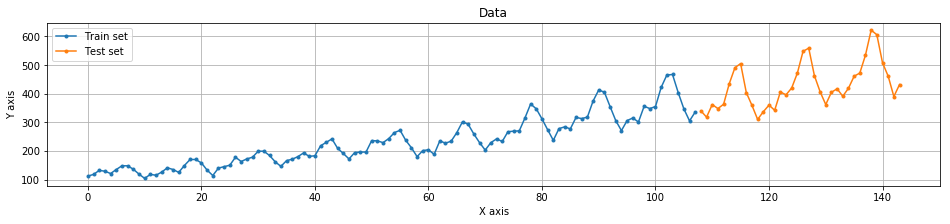

0.0 107.0
112.0 336.0


In [3]:
nData = data.shape[0]
nTrain = int(np.ceil(0.75*nData))

print('Total data: %i\nTrain data: %i\nTest data : %i' %(nData, nTrain, nData-nTrain))

train_set = data[0:nTrain,:]
test_set  = data[nTrain:,:]

fig = plt.figure(0,(16,3))
plt.plot(train_set[:,0],train_set[:,1],'.-')
plt.plot(test_set[:,0],test_set[:,1],'.-')
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend(('Train set', 'Test set'))
plt.grid()
plt.show(fig)

print(train_set[0,0],train_set[-1,0])
print(train_set[0,1],train_set[-1,1])

# Model

This model have the following structure:

$$
y = f_{\theta} + \eta
$$

where, $\eta\sim N(0,\sigma_{\eta}^2)$ and $\theta$ are the parameters for $f(\cdot)$. Then, the probability associated to $(x,y)$ is given by:

$$
p(y|f(\cdot), x) = \frac{1}{\sqrt{2\pi\sigma_{\eta}^2}}\exp{\left(-\frac{(y-f(x))^2}{2\sigma_{\eta}^2}\right)}
$$

In this case, the model for $f(\cdot)$ is a polynomial. Then, $\theta = [\theta_0, \theta_1, ..., \theta_n]$ where:

$$
f(x) = \theta_0 + \theta_1x + ...+ \theta_n x^n
$$

In [4]:
import theano.tensor as tt

grade = 3

k = np.linspace(0,grade,grade+1)
X = train_set[:,0]
print('X shape: %s' % X.shape)

Y = train_set[:,1]
print('Y shape: %s' % Y.shape)


basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    theta = pm.Normal('theta', mu=0, sd=100, shape = 4)
    # theta3 = pm.Normal('theta3', mu=0, sd=100)
    # sigma = pm.HalfNormal('sigma', sd=10)
    sigma = pm.HalfNormal('sigma_y', sd=200)

    # Expected value of outcome
    mu_obs = theta[3]+theta[2]*X+theta[1]*np.power(X,2)+theta[0]*np.power(X,3)
    # mu_obs = np.sum(np.dot(theta,X_aux),axis = 1)
    print('mu_obs shape: %s'% mu_obs.shape)
        
    # Model
    Y_obs = pm.Normal('Y_obs', mu=mu_obs, sd=sigma, observed=Y)
    
    ## sample using MEtropolis
    # step = pm.Metropolis()
    # trace = pm.sample(10000, step)

map_estimate = pm.find_MAP(model=basic_model)

print(map_estimate)

X shape: 108
Y shape: 108
mu_obs shape: Shape.0
         Current function value: 556.650576
         Iterations: 23
         Function evaluations: 78
         Gradient evaluations: 66
{'theta': array([  5.99618870e-05,   1.88173929e-03,   1.67822943e+00,
         1.15242941e+02]), 'sigma_y_log_': array(3.510210322295801)}


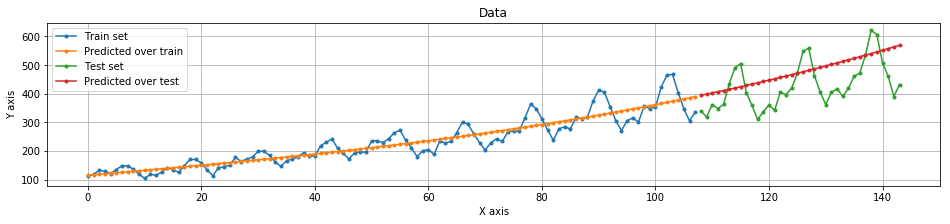

In [5]:
# theta = [float(map_estimate['theta1']),float(map_estimate['theta0'])]
theta = map_estimate['theta']
# theta = [float(map_estimate['theta3']), float(map_estimate['theta2']), float(map_estimate['theta1']),float(map_estimate['theta0'])]

X_test = test_set[:,0]
Y_test = test_set[:,1]

Y_train_hat = np.polyval(theta,X)
Y_hat = np.polyval(theta,X_test)

fig = plt.figure(0,(16,3))
plt.plot(X,Y,'.-')
plt.plot(X,Y_train_hat,'.-')
plt.plot(X_test,Y_test,'.-')
plt.plot(X_test,Y_hat ,'.-')
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend(('Train set', 'Predicted over train', 'Test set', 'Predicted over test'))
plt.grid()
plt.show(fig)

In [6]:
import mle
import theano.tensor as tt
import theano

# for ommit AttributeError: x has no test value
theano.config.compute_test_value = 'ignore'

def fpol(a,x):
    return a[3]+a[2]*x+a[1]*np.power(x,2)+a[0]*np.power(x,3)

X = train_set[:,0]

print('X shape: %s' % X.shape)

Y = train_set[:,1]
print('Y shape: %s' % Y.shape)

# Define model
x = mle.var('x', observed=True, vector=True)
y = mle.var('y', observed=True, vector=True)

theta1 = mle.var('theta1')
theta2 = mle.var('theta2')
theta3 = mle.var('theta3')
theta4 = mle.var('theta4')
sigma = mle.var('sigma')



model = mle.Normal(y, theta[3]+theta[2]*X+theta[1]*np.power(X,2)+theta[0]*np.power(X,3) + theta1*tt.sin(theta2*x + theta3)*tt.exp(theta4*x), sigma)


# Fit model to data
result = model.fit({'x': X, 'y': Y}, {'theta1': 100, 'theta2': 60, 'theta3': -10, 'theta4': 0.01, 'sigma': 1})
print(result)

X shape: 108
Y shape: 108
Optimization terminated successfully.
         Current function value: 467.374536
         Iterations: 108
         Function evaluations: 146
         Gradient evaluations: 146
 fit_time: 0.0792540000000006
      fun: 467.3745363292269
 hess_inv: array([[  1.57076006e+00,   5.30863382e-02,  -2.45358009e-05,
          1.23919589e-03,  -4.79240373e-05],
       [  5.30863382e-02,   7.92867447e+00,   1.34670568e-04,
         -1.78469486e-02,  -7.59869895e-03],
       [ -2.45358009e-05,   1.34670568e-04,   7.73092900e-06,
         -6.30521763e-04,  -5.39010001e-08],
       [  1.23919589e-03,  -1.78469486e-02,  -6.30521763e-04,
          5.54756012e-02,   1.33867639e-05],
       [ -4.79240373e-05,  -7.59869895e-03,  -5.39010001e-08,
          1.33867639e-05,   7.85009556e-06]])
      jac: array([  4.07720563e-09,   6.53180664e-09,  -5.34210635e-06,
        -5.82265971e-08,   3.43904313e-06])
  message: 'Optimization terminated successfully.'
     nfev: 146
      nit

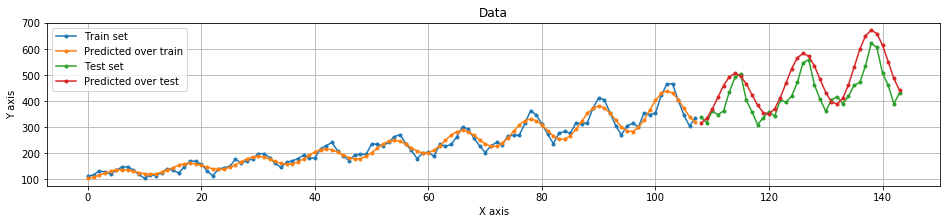

In [7]:
theta_sin = [float(result.x['theta1']), float(result.x['theta2']), float(result.x['theta3']),float(result.x['theta4'])]

X_test = test_set[:,0]
Y_test = test_set[:,1]

Y_train_hat = np.polyval(theta,X)+ float(result.x['theta1'])*np.sin(float(result.x['theta2'])*X + float(result.x['theta3']))*np.exp(float(result.x['theta4'])*X)
Y_hat = np.polyval(theta,X_test) + float(result.x['theta1'])*np.sin(float(result.x['theta2'])*X_test + float(result.x['theta3']))*np.exp(float(result.x['theta4'])*X_test)

fig = plt.figure(0,(16,3))
plt.plot(X,Y,'.-')
plt.plot(X,Y_train_hat,'.-')
plt.plot(X_test,Y_test,'.-')
plt.plot(X_test,Y_hat ,'.-')
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend(('Train set', 'Predicted over train', 'Test set', 'Predicted over test'))
plt.grid()
plt.show(fig)

In [8]:
def f_pol_sin(x,a,b):
    return a[3]+a[2]*x+a[1]*np.power(x,2)+a[0]*np.power(x,3)+ b[0]*np.sin(b[1]*x+b[2])*np.exp(b[3]*x)

X = train_set[:,0]

print('X shape: %s' % X.shape)

Y = train_set[:,1]
print('Y shape: %s' % Y.shape)

# Define model
x = mle.var('x', observed=True, vector=True)
y = mle.var('y', observed=True, vector=True)

theta1 = mle.var('theta1')
theta2 = mle.var('theta2')
theta3 = mle.var('theta3')
theta4 = mle.var('theta4')
sigma = mle.var('sigma')


model = mle.Normal(y, f_pol_sin(x,theta,theta_sin) + theta1*tt.sin(theta2*x + theta3)*tt.exp(theta4*x), sigma)


# Fit model to data
result = model.fit({'x': X, 'y': Y}, {'theta1': 10, 'theta2': 1000, 'theta3': -10, 'theta4': 0.1, 'sigma': 100})
print(result)

X shape: 108
Y shape: 108
Optimization terminated successfully.
         Current function value: 415.482938
         Iterations: 118
         Function evaluations: 213
         Gradient evaluations: 206
 fit_time: 0.09565800000000024
      fun: 415.4829383773048
 hess_inv: array([[  5.95287611e-01,   2.48196235e-02,  -2.52470751e-06,
         -1.03595308e-04,  -3.89096379e-05],
       [  2.48196235e-02,   4.55356907e+00,   1.16364295e-04,
         -7.64370831e-03,  -6.06573469e-03],
       [ -2.52470751e-06,   1.16364295e-04,   7.27961493e-06,
         -5.49415010e-04,  -1.20106890e-07],
       [ -1.03595308e-04,  -7.64370831e-03,  -5.49415010e-04,
          4.68237082e-02,   7.52714030e-06],
       [ -3.89096379e-05,  -6.06573469e-03,  -1.20106890e-07,
          7.52714030e-06,   8.97609363e-06]])
      jac: array([ -1.58020511e-11,   3.50755694e-12,  -2.77709878e-08,
        -4.15474978e-10,  -4.67393564e-09])
  message: 'Optimization terminated successfully.'
     nfev: 213
      ni

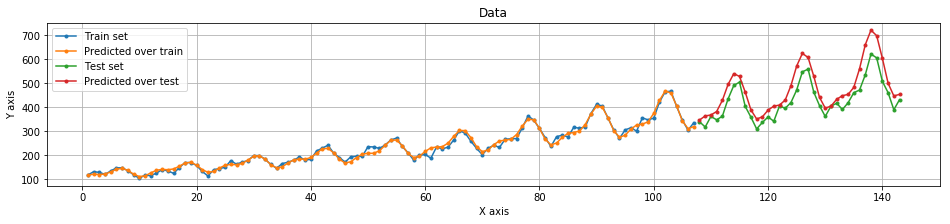

In [9]:
theta_sin_sin = [float(result.x['theta1']), float(result.x['theta2']), float(result.x['theta3']),float(result.x['theta4'])]

X_test = test_set[:,0]
Y_test = test_set[:,1]

Y_train_hat = f_pol_sin(X,theta,theta_sin)+ float(result.x['theta1'])*np.sin(float(result.x['theta2'])*X + float(result.x['theta3']))*np.exp(float(result.x['theta4'])*X)
Y_hat = f_pol_sin(X_test,theta,theta_sin) + float(result.x['theta1'])*np.sin(float(result.x['theta2'])*X_test + float(result.x['theta3']))*np.exp(float(result.x['theta4'])*X_test)

fig = plt.figure(0,(16,3))
plt.plot(X[1:],Y[1:],'.-')
plt.plot(X[1:],Y_train_hat[1:],'.-')
plt.plot(X_test,Y_test,'.-')
plt.plot(X_test,Y_hat ,'.-')
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend(('Train set', 'Predicted over train', 'Test set', 'Predicted over test'))
plt.grid()
plt.show(fig)

In [10]:
argMSE = (Y_test-Y_hat)**2
MSE = np.mean(argEMS)
print("MSE: %s" % EMS)

NameError: name 'argEMS' is not defined